In [0]:
import glob
import pickle
import numpy as np
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation, Conv1D, Flatten
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import collections
import matplotlib.pyplot as plt
import random

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
print('Press 1 - Relax')
print('Press 2 - Active')
print('Enter your emotion:')
emotion = input()

Press 1 - Relax
Press 2 - Active
Enter your emotion:
1


In [0]:
if emotion == "1":
  location_notes = '/content/drive/My Drive/master ds nida/DL/relax_notes'
else:
  location_notes = '/content/drive/My Drive/master ds nida/DL/active_notes'

In [0]:
def train_network(emotion, location_notes):
    
    """ This function calls all other functions and trains the LSTM"""
    
    notes = get_notes(emotion, location_notes)

    # get amount of pitch names
    n_vocab = len(set(notes))
    print(n_vocab)

    network_input, network_output = prepare_sequences(notes, n_vocab)

    model = create_network(network_input, n_vocab)
    #model = simple_wavenet(n_vocab)

    train(model, network_input, network_output)

In [0]:
def get_notes(emotion, location_notes):
    
    """ Extracts all notes and chords from midi files in the ./midi_songs 
    directory and creates a file with all notes in string format"""
    
    notes = []

    if emotion == "1":
        print("Your emotion is relax.")
        location = "/content/drive/My Drive/master ds nida/DL/midi/relax/*.mid"
    else:
        print("Your emotion is active.")
        location = "/content/drive/My Drive/master ds nida/DL/midi/active/*.mid"

    count = 1
    for file in glob.glob(location):
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None
        
        #grouping based on different instruments
        s2 = instrument.partitionByInstrument(midi)

        try:
        #Looping over all the instruments
          for part in s2.parts:
              #select elements of only piano
              if 'Piano' in str(part): 
                  notes_to_parse = part.recurse() 
            
                  #finding whether a particular element is note or a chord
                  for element in notes_to_parse:
                      #note
                      if isinstance(element, note.Note):
                          notes.append(str(element.pitch))
                      #chord
                      elif isinstance(element, chord.Chord):
                          notes.append('.'.join(str(n) for n in element.normalOrder))
          print(count)
          count+=1
        except: # file has notes in a flat structure
          notes_to_parse = midi.flat.notes

        # try: # file has instrument parts
        #     s2 = instrument.partitionByInstrument(midi)
        #     notes_to_parse = s2.parts[0].recurse() 
        # except: # file has notes in a flat structure
        #     notes_to_parse = midi.flat.notes

        # for element in notes_to_parse:
        #     if isinstance(element, note.Note):
        #         notes.append(str(element.pitch))
        #     elif isinstance(element, chord.Chord):
        #         notes.append('.'.join(str(n) for n in element.normalOrder))

    #### EDA ####
    count_notes = dict(collections.Counter(notes).most_common(10))
    # print(count_notes)
    names = list(count_notes.keys())
    values = list(count_notes.values())
    plt.bar(range(len(count_notes)),values,tick_label=names)
    plt.show()

    with open(location_notes, 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes

In [0]:
def prepare_sequences(notes, n_vocab):
    
    """ Prepare the sequences which are the inputs for the LSTM """
    
    # sequence length should be changed after experimenting with different numbers
    sequence_length = 30

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

    # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    network_input = network_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)

In [0]:
#LSTM

def create_network(network_input, n_vocab):
    
    """ Creates the structure of the neural network """
    
    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True
    ))
    model.add(Dropout(0.3))
    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(512))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

In [0]:
#Wavenet
def simple_wavenet(n_vocab):
  no_of_kernels=64
  no_of_timesteps = 24
  num_of_blocks= int(np.sqrt(no_of_timesteps)) - 1   #no. of stacked conv1d layers

  model = Sequential()
  for i in range(num_of_blocks):
    model.add(Conv1D(no_of_kernels,3,dilation_rate=(2**i),padding='causal',activation='relu'))
  model.add(Conv1D(1, 1, activation='relu', padding='causal'))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(n_vocab, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
  return model

In [0]:
def train(model, network_input, network_output):
    
    """ train the neural network """
    
    filepath = "weights-improvement-{epoch:03d}-{loss:.4f}-bigger.hdf5"
    checkpoint = ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
    )
    callbacks_list = [checkpoint]

    # experiment with different epoch sizes and batch sizes
    history = model.fit(network_input, network_output, epochs=100, batch_size=64, callbacks=callbacks_list)

    plt.plot(history.history['loss'], label='train')
    plt.legend()
    plt.show()

Your emotion is relax.
Parsing /content/drive/My Drive/master ds nida/DL/midi/relax/Zorro.mid
1
Parsing /content/drive/My Drive/master ds nida/DL/midi/relax/UnPetileMixage.mid
2
Parsing /content/drive/My Drive/master ds nida/DL/midi/relax/UnderTheSea.mid
3
Parsing /content/drive/My Drive/master ds nida/DL/midi/relax/Waterfall.mid
4
Parsing /content/drive/My Drive/master ds nida/DL/midi/relax/Watermark.mid
5
Parsing /content/drive/My Drive/master ds nida/DL/midi/relax/Lftmweb.mid
6
Parsing /content/drive/My Drive/master ds nida/DL/midi/relax/Luvntune.mid
7
Parsing /content/drive/My Drive/master ds nida/DL/midi/relax/Morning.mid
8
Parsing /content/drive/My Drive/master ds nida/DL/midi/relax/ThisIsTheMoment.mid
9
Parsing /content/drive/My Drive/master ds nida/DL/midi/relax/Tranquility.mid
10
Parsing /content/drive/My Drive/master ds nida/DL/midi/relax/TurnAround.mid
11
Parsing /content/drive/My Drive/master ds nida/DL/midi/relax/TimeToSayGoodbye.mid
12
Parsing /content/drive/My Drive/mast

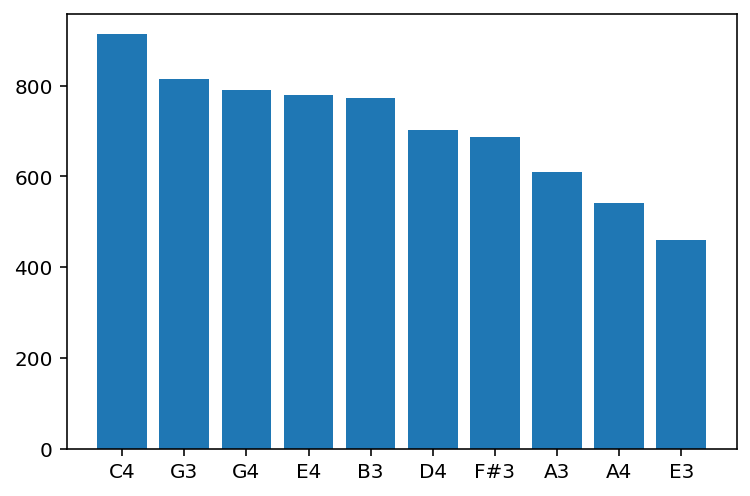

209
Epoch 1/100
17262/17262 [==============================] - 85s 5ms/step - loss: 4.3040
Epoch 2/100
17262/17262 [==============================] - 85s 5ms/step - loss: 4.1911
Epoch 3/100
17262/17262 [==============================] - 84s 5ms/step - loss: 4.1332
Epoch 4/100
17262/17262 [==============================] - 85s 5ms/step - loss: 4.0830
Epoch 5/100
17262/17262 [==============================] - 85s 5ms/step - loss: 4.0657
Epoch 6/100
17262/17262 [==============================] - 85s 5ms/step - loss: 4.0473
Epoch 7/100
17262/17262 [==============================] - 84s 5ms/step - loss: 4.0351
Epoch 8/100
17262/17262 [==============================] - 84s 5ms/step - loss: 4.0248
Epoch 9/100
17262/17262 [==============================] - 85s 5ms/step - loss: 4.0102
Epoch 10/100
17262/17262 [==============================] - 83s 5ms/step - loss: 3.9958
Epoch 11/100
17262/17262 [==============================] - 84s 5ms/step - loss: 4.0629
Epoch 12/100
17262/17262 [===========

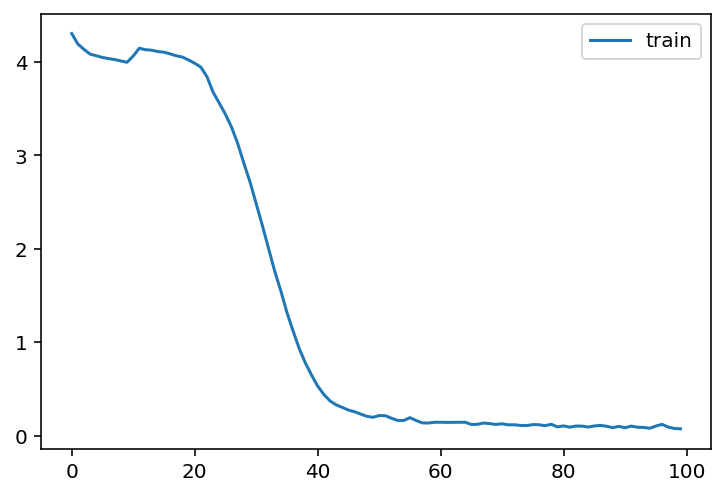

In [0]:
train_network(emotion, location_notes)

In [0]:
def generate(location_notes):
    """ Generates the midi file """
    #load the notes used to train the model
    with open(location_notes, 'rb') as filepath:
        notes = pickle.load(filepath)

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))
    # Get all pitch names
    n_vocab = len(set(notes))

    network_input, normalized_input = prepare_sequences(notes, pitchnames, n_vocab)
    model = create_network(normalized_input, n_vocab)
    #model = simple_wavenet(n_vocab)
    prediction_output = generate_notes(model, network_input, pitchnames, n_vocab)
    create_midi(prediction_output)

In [0]:
def prepare_sequences(notes, pitchnames, n_vocab):
    
    """ Prepare the sequences used by the Neural Network """
    
    #    map back from integers to notes
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 30
    network_input = []
    output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    normalized_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    normalized_input = normalized_input / float(n_vocab)

    return (network_input, normalized_input)

In [0]:
def create_network(network_input, n_vocab):
    
    """ Creates the structure of the neural network """
    
    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True
    ))
    model.add(Dropout(0.3))
    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(512))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # Load the weights to each node
    # model.load_weights('/content/weights-improvement-100-3.4356-bigger.hdf5')
    model.load_weights('/content/drive/My Drive/master ds nida/DL/project/weights-improvement-relax-100-0.0726-bigger.hdf5')

    return model

In [0]:
def generate_notes(model, network_input, pitchnames, n_vocab):
    
    """ Generate notes from the neural network based on a sequence of notes """
    
    # pick a random sequence from the input as a starting point for the prediction
    start = np.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
    print(int_to_note)

    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)
        # print(prediction)

        rand = random.random()

        # if rand < 0.8:
        #   index = np.argmax(prediction,axis=0)
        # elif rand < 0.9:
        #   prob_sort = np.argpartition(prediction,2)
        #   index = prob_sort[1]
        # else:
        #   prob_sort = np.argpartition(prediction,3)
        #   index = prob_sort[2]

        index = np.argmax(prediction) # numpy array of predictions
        result = int_to_note[index] # indexing the note with the highest probability
        prediction_output.append(result) # that note is the prediction output

        pattern.append(index)
        pattern = pattern[1:len(pattern)]
        # print(pattern)

    return prediction_output

In [0]:
def create_midi(prediction_output):
    
    """ Converts the output from the prediction to notes and create a midi file
        from the notes """
    
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.SnareDrum()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.SnareDrum()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='test_output5.mid')

In [0]:
# generate(location_notes)
generate('/content/drive/My Drive/master ds nida/DL/project/relax_notes_lstm')

{0: '0', 1: '0.1', 2: '0.2', 3: '0.2.3.7', 4: '0.2.7', 5: '0.3', 6: '0.3.6', 7: '0.3.6.7', 8: '0.3.6.8', 9: '0.3.7', 10: '0.4', 11: '0.4.6.7', 12: '0.4.7', 13: '0.4.7.8', 14: '0.5', 15: '0.6', 16: '1', 17: '1.2', 18: '1.2.6', 19: '1.3', 20: '1.3.5.8', 21: '1.3.8', 22: '1.4', 23: '1.4.6', 24: '1.4.7', 25: '1.5', 26: '1.5.8', 27: '1.5.9', 28: '1.6', 29: '1.6.7', 30: '1.7', 31: '10', 32: '10.0', 33: '10.1', 34: '10.1.5', 35: '10.11', 36: '10.2', 37: '10.3', 38: '11', 39: '11.0', 40: '11.1', 41: '11.1.4', 42: '11.2', 43: '11.2.3.5', 44: '11.2.4', 45: '11.2.4.5', 46: '11.2.5', 47: '11.2.5.6', 48: '11.2.5.7', 49: '11.2.6', 50: '11.3', 51: '11.3.5', 52: '11.3.6', 53: '11.3.6.7', 54: '11.4', 55: '2', 56: '2.3', 57: '2.4', 58: '2.4.9', 59: '2.5', 60: '2.5.9', 61: '2.6', 62: '2.6.7', 63: '2.6.9', 64: '2.7', 65: '2.8', 66: '3', 67: '3.6', 68: '3.6.10', 69: '3.6.8.11.0', 70: '3.7', 71: '3.7.11', 72: '3.8', 73: '3.9', 74: '4', 75: '4.5', 76: '4.5.9.0', 77: '4.6', 78: '4.6.7', 79: '4.6.7.10', 80: '4